# Test shifting template experiments

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import umap
import glob
import pickle
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
train_vae_modules.set_all_seeds()

In [3]:
# Read in config variables
config_filename = "config_embed_shift_template_experiment.tsv"

params = utils.read_config(config_filename)

In [4]:
# Load parameters
local_dir = params["local_dir"]
raw_compendium_filename = params["raw_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]
raw_template_filename = params["raw_template_filename"]
mapped_template_filename = params["mapped_template_filename"]
normalized_template_filename = params["normalized_template_filename"]
latent_dim = params['latent_dim']
training_stats_dir = params["training_stats_dir"]
vae_model_dir = params["vae_model_dir"]
scaler_filename = params['scaler_transform_filename']
metadata_filename = params["metadata_filename"]
metadata_delimiter = params["metadata_delimiter"]
experiment_id_colname = params['metadata_experiment_colname']
sample_id_colname = params['metadata_sample_colname']
project_id = params['project_id']
num_simulated_experiments = params['num_simulated']
simulated_data_dir = params["simulated_data_dir"]

In [5]:
assert os.path.exists(raw_compendium_filename)

## Setup directories

In [6]:
utils.setup_dir(config_filename)

## Process compendium data

In [7]:
train_vae_modules.normalize_expression_data(config_filename,
                                            raw_compendium_filename,
                                            normalized_compendium_filename)

input: dataset contains 273 samples and 5000 genes
Output: normalized dataset contains 273 samples and 5000 genes


## Train VAE

input dataset contains 273 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 246 samples, validate on 27 samples
Epoch 1/10
246/246 [==============================] - 21s 84ms/step - loss: 2340.0547 - kl_loss: 13.9695 - recons_loss: 2340.0549 - val_loss: 2576.0480 - val_kl_loss: 138.0642 - val_recons_loss: 2576.0481
Epoch 2/10
246/246 [==============================] - 21s 83ms/step - loss: 2167.1981 - kl_loss: 13.5955 - recons_loss: 2167.1982 - val_loss: 2336.0543 - val_kl_loss: 77.9998 - val_recons_loss: 2336.0542
Epoch 3/10
246/246 [==============================] - 22s 90ms/step - loss: 2154.3693 - kl_loss: 13.6479 - recons_loss: 2154.3691 - val_loss: 2209.4096 - val_kl_loss: 48.1001 - val_recons_loss: 2209.4097
Epoch 4/10
246/246 [==============================] 

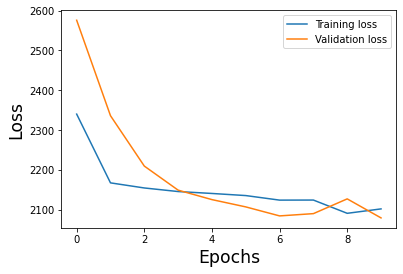

In [8]:
# Train VAE
train_vae_modules.train_vae(config_filename,
                            normalized_compendium_filename)

## Process template experiment

In order to simulate a new gene expression experiment, we will need to encode this experiment into the learned latent space. This requires that the feature space (i.e. genes) in the template experiment match the features in the compendium used to train the VAE model. These cells process the template experiment to be of the expected input format:

* Template data is expected to be a matrix that is sample x gene
* Template experiment is expected to have the same genes as the compendium experiment. Genes that are in the template experiment but not in the compendium are removed. Genes that are in the compendium but missing in the template experiment are added and the gene expression value is set to the median gene expression value of that gene across the samples in the compendium.
* Template values are expected to be within the range (i.e. both the template and compendium expression measurements are estimated counts)

In [9]:
simulate_expression_data.process_template_experiment(
    raw_template_filename,
    normalized_compendium_filename,
    scaler_filename,
    mapped_template_filename,
    normalized_template_filename,
)

(5, 5000)
(273, 5000)


In [10]:
template = pd.read_csv(raw_template_filename, sep="\t", index_col=0, header=0)
print(template.shape)
template.head()

(5, 5000)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000119953.12,ENSG00000119965.12,ENSG00000119969.14,ENSG00000119973.5,ENSG00000119977.20,ENSG00000119979.16,ENSG00000119986.6,ENSG00000120008.15,ENSG00000120029.12,ENSG00000120049.18
SRR592745,52338,5,449,959,237,5,21814,1784,1228,690,...,587,256,58,0,2602,605,327,2120,1222,77
SRR592746,27719,2,630,429,195,45,14051,832,933,825,...,748,199,62,0,2066,458,635,1331,1236,79
SRR592747,34242,2,1329,487,183,4,17662,1411,1383,1015,...,1320,234,59,0,2698,568,706,1595,1558,45
SRR592748,11768,88,612,860,370,8,8229,1927,451,1922,...,689,349,503,1,3163,586,113,2903,1099,225
SRR592749,16803,713,855,799,447,4,5676,2099,379,2185,...,864,431,797,0,4314,659,128,2332,971,123


## Simulation

In [11]:
# Run simulation
simulate_expression_data.embed_shift_template_experiment(
    normalized_compendium_filename,
    normalized_template_filename,
    vae_model_dir,
    project_id,
    scaler_filename,
    local_dir,
    latent_dim,
    num_simulated_experiments,
    simulated_data_dir,
)

## Visualize latent transform compendium

In [12]:
# Load VAE models
model_encoder_filename = glob.glob(os.path.join(
        vae_model_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(os.path.join(
    vae_model_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

In [13]:
pca = PCA(n_components=2)

In [14]:
# Read data
normalized_compendium = pd.read_csv(normalized_compendium_filename, header=0, sep="\t", index_col=0)

In [15]:
# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=normalized_compendium.index)

# Get and save PCA model
model = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['experiment_id'] = 'background'

In [16]:
# Embedding of real template experiment (encoded)
template_filename = os.path.join(local_dir,
    "template_normalized_data_"+project_id+"_test.tsv")

template_data = pd.read_csv(template_filename, header=0, sep='\t', index_col=0)

# Encode template experiment into latent space
template_encoded = loaded_model.predict_on_batch(template_data)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=template_data.index)

template_PCAencoded = model.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['experiment_id'] = 'template_experiment'

In [17]:
# Embedding of simulated experiment (encoded)
encoded_simulated_filename = os.path.join(simulated_data_dir,
    "selected_simulated_encoded_data_"+project_id+"_1.tsv")

simulated_encoded_df = pd.read_csv(encoded_simulated_filename,header=0, sep='\t', index_col=0)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [18]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(283, 3)


,1,2,experiment_id
SRR493816,1.848396,1.286768,background
SRR493817,1.990783,0.579773,background
SRR547975,2.150964,3.926265,background
SRR547973,2.045691,1.005350,background
SRR547968,2.227068,1.426534,background


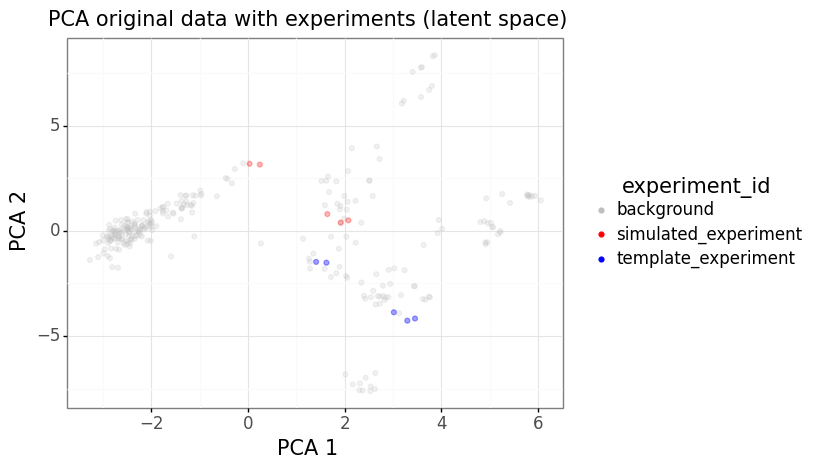

<ggplot: (8743187421913)>


In [19]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.1, 
                  color='red')

print(fig)